<a href="https://colab.research.google.com/github/Haadi-kp/Image_Colourization/blob/main/Colab_Notebooks/Copy_of_Unet_with_pretrained_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

!pip install fastai==2.4


INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.10,>=1.7.0 (from fastai) (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1)
ERROR: No matching distribution found for torch<1.10,>=1.7.0


In [ ]:

coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [ ]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


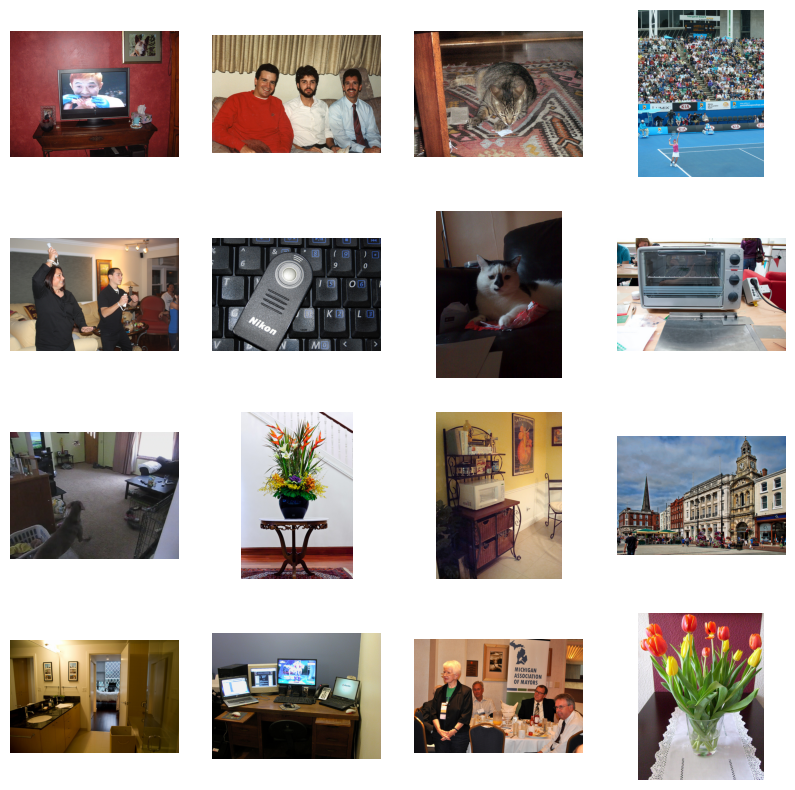

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


In [ ]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)

    def forward(self, x):
        return self.model(x)

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [ ]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

        self.fake_color = None

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self, L):
        # Compute fake colorization (ab channels) using the Generator
        self.fake_color = self.net_G(L)
        return self.fake_color

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()

    def optimize(self):
        self.forward(self.L)
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr(img1, img2):
    """
    Calculate PSNR between two images.
    Args:
        img1: Ground truth image (RGB, range [0, 1]).
        img2: Predicted image (RGB, range [0, 1]).
    Returns:
        PSNR value.
    """
    psnr_value = peak_signal_noise_ratio(img1, img2, data_range=1.0)
    return psnr_value

def calculate_ssim(img1, img2):
    """
    Calculate SSIM between two images.
    Args:
        img1: Ground truth image (RGB, range [0, 1]).
        img2: Predicted image (RGB, range [0, 1]).
    Returns:
        SSIM value.
    """
    # Explicitly set win_size and handle multichannel
    ssim_value = structural_similarity(
        img1, img2, win_size=7, channel_axis=-1, data_range=1.0
    )
    return ssim_value


In [ ]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize_with_metrics(model, data, save=True):
    """
    Visualize the model's output along with metrics like PSNR and SSIM.
    Args:
        model: MainModel instance.
        data: A batch of data (e.g., from validation loader).
        save: Whether to save the visualization as a file.
    """
    model.net_G.eval()  # Ensure the Generator is in evaluation mode
    with torch.no_grad():
        # Setup the input
        model.setup_input(data)

        # Pass L-channel through the Generator
        fake_color = model.forward(model.L)  # Pass the L tensor explicitly

    model.net_G.train()  # Switch back to training mode

    # Generate RGB images from LAB
    fake_imgs = lab_to_rgb(model.L, fake_color)
    real_imgs = lab_to_rgb(model.L, model.ab)

    # Plot and visualize results
    fig = plt.figure(figsize=(15, 8))
    for i in range(min(len(fake_imgs), 5)):  # Display up to 5 images
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(model.L[i][0].cpu(), cmap='gray')
        ax.set_title("Grayscale (L)")
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 6)
        ax.imshow(fake_imgs[i])
        ax.set_title("Colorized (Fake)")
        ax.axis("off")

        ax = plt.subplot(3, 5, i + 11)
        ax.imshow(real_imgs[i])
        ax.set_title("Ground Truth")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Optionally save the visualization
    if save:
        fig.savefig(f"visualization_epoch_{time.time():.0f}.png")



def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [ ]:


# # Move model to the appropriate device
# model = MainModel().to(device)

# # Print the model summary
# print("Generator Summary:")
# summary(model.net_G, input_size=(1, 256, 256))  # Input: Grayscale image (1 channel)

# print("\nDiscriminator Summary:")
# summary(model.net_D, input_size=(3, 256, 256))  # Input: L and ab combined (3 channels)


In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Call resnet18 to create a model instance instead of passing the function
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 20)


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.08554


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.08271


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.08229


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.08206


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.08189


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.08172


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.08165


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.08139


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.08130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.08116


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.08077


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.08059


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.08019


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.07949


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.07901


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.07824


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.07722


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.07672


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.07540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.07478


In [ ]:
save_path = "/content/drive/MyDrive/saved_model/"
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist
model_file_path = os.path.join(save_path, "1:pretrained_generator_model.pth")

torch.save(net_G, model_file_path)
print(f"Pretrained generator model saved at: {model_file_path}")

Pretrained generator model saved at: /content/drive/MyDrive/saved_model/pretrained_generator_model.pth


In [ ]:
model_file_path = "/content/drive/MyDrive/saved_model/pretrained_generator_model.pth"

# Load the model
net_G = torch.load(model_file_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Set the model to evaluation mode (important for inference)
net_G.eval()

# Check if the model is loaded successfully
print("Pretrained Generator Model loaded successfully!")

<ipython-input-18-d308b8072daa>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_G = torch.load(model_file_path, map_location=torch.device("cuda" if torch.cuda.is_availa

Pretrained Generator Model loaded successfully!


In [ ]:
def train_model_with_metrics(model, train_dl, val_dl, epochs, display_every=250, visualize_every=2):
    """
    Train the model and log PSNR and SSIM metrics during training.
    Args:
        model: MainModel instance.
        train_dl: Training dataloader.
        val_dl: Validation dataloader.
        epochs: Number of epochs to train.
        display_every: Interval to display visualizations and metrics.
        visualize_every: Interval to display images and print current epoch.
    """
    data_val = next(iter(val_dl))  # A batch for visualization
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data)  # Prepare data
            model.optimize()        # Optimize model
            update_losses(model, loss_meter_dict, count=data['L'].size(0))
            i += 1

            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}, Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)

        # Visualize results at the specified interval
        if (e + 1) % visualize_every == 0:
            print(f"\nDisplaying results for Epoch {e+1}/{epochs}...\n")
            visualize_with_metrics(model, data_val, save=False)


<ipython-input-22-d6d3dfa1cd0f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_G = torch.load(model_path, map_location=device)


model initialized with norm initialization


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 1/20, Iteration 250/500
loss_D_fake: 0.61630
loss_D_real: 0.61194
loss_D: 0.61412
loss_G_GAN: 1.03032
loss_G_L1: 8.37673
loss_G: 9.40704

Epoch 1/20, Iteration 500/500
loss_D_fake: 0.58491
loss_D_real: 0.58747
loss_D: 0.58619
loss_G_GAN: 1.11505
loss_G_L1: 8.68513
loss_G: 9.80018


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/20, Iteration 250/500
loss_D_fake: 0.58769
loss_D_real: 0.59496
loss_D: 0.59133
loss_G_GAN: 1.10360
loss_G_L1: 8.90552
loss_G: 10.00912

Epoch 2/20, Iteration 500/500
loss_D_fake: 0.58384
loss_D_real: 0.59755
loss_D: 0.59069
loss_G_GAN: 1.10907
loss_G_L1: 8.97653
loss_G: 10.08561


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/20, Iteration 250/500
loss_D_fake: 0.59366
loss_D_real: 0.61520
loss_D: 0.60443
loss_G_GAN: 1.04751
loss_G_L1: 8.80193
loss_G: 9.84945

Epoch 3/20, Iteration 500/500
loss_D_fake: 0.58996
loss_D_real: 0.61263
loss_D: 0.60130
loss_G_GAN: 1.05689
loss_G_L1: 8.83223
loss_G: 9.88912


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/20, Iteration 250/500
loss_D_fake: 0.59278
loss_D_real: 0.62000
loss_D: 0.60639
loss_G_GAN: 1.03376
loss_G_L1: 8.60954
loss_G: 9.64330

Epoch 4/20, Iteration 500/500
loss_D_fake: 0.58861
loss_D_real: 0.61678
loss_D: 0.60269
loss_G_GAN: 1.03994
loss_G_L1: 8.64083
loss_G: 9.68077


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5/20, Iteration 250/500
loss_D_fake: 0.59506
loss_D_real: 0.62189
loss_D: 0.60847
loss_G_GAN: 1.01236
loss_G_L1: 8.45910
loss_G: 9.47146

Epoch 5/20, Iteration 500/500
loss_D_fake: 0.59038
loss_D_real: 0.61871
loss_D: 0.60454
loss_G_GAN: 1.02507
loss_G_L1: 8.47297
loss_G: 9.49804

Displaying results for Epoch 5/20...



<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 31 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


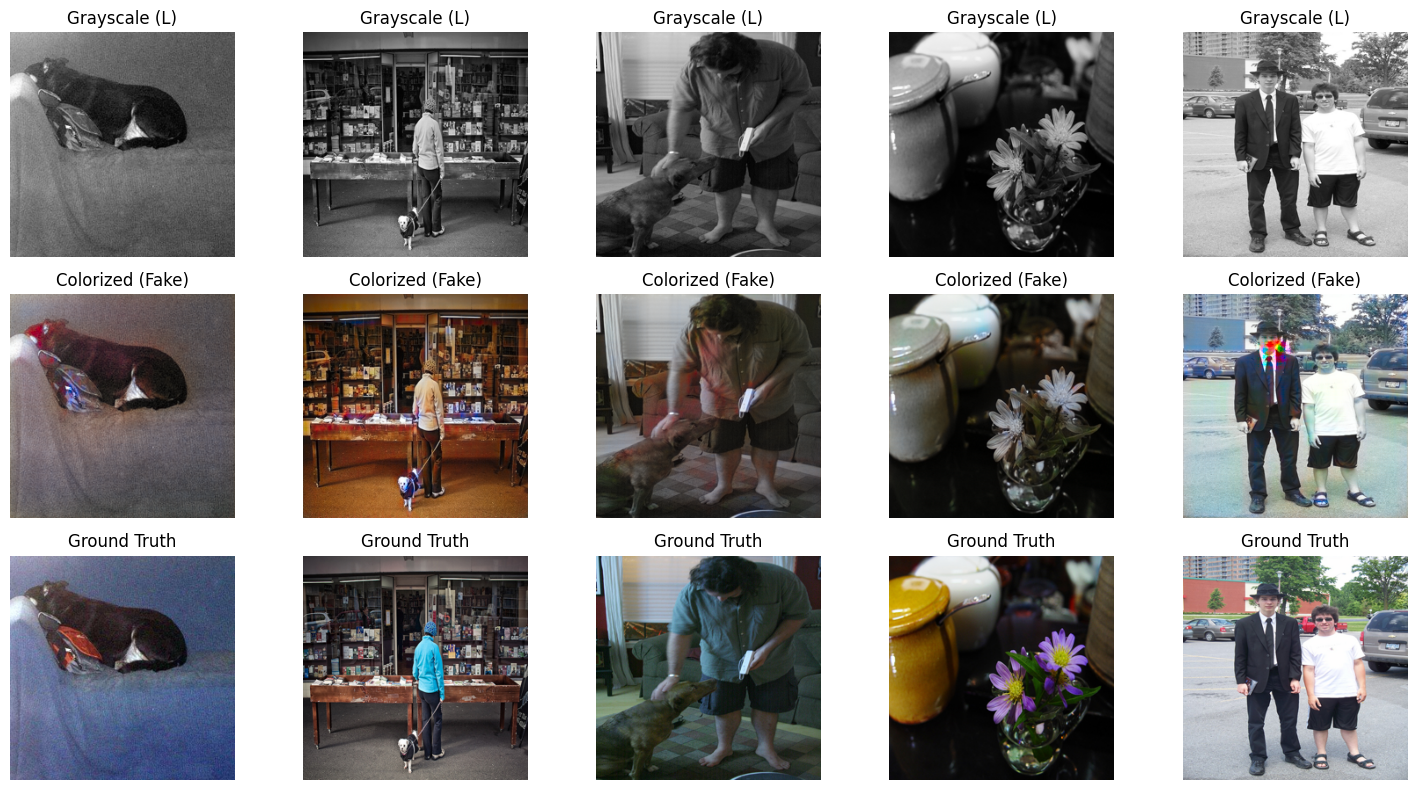

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 6/20, Iteration 250/500
loss_D_fake: 0.59674
loss_D_real: 0.62627
loss_D: 0.61150
loss_G_GAN: 1.00030
loss_G_L1: 8.25290
loss_G: 9.25320

Epoch 6/20, Iteration 500/500
loss_D_fake: 0.59817
loss_D_real: 0.62270
loss_D: 0.61044
loss_G_GAN: 1.00150
loss_G_L1: 8.26769
loss_G: 9.26919


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 7/20, Iteration 250/500
loss_D_fake: 0.59506
loss_D_real: 0.62989
loss_D: 0.61248
loss_G_GAN: 0.99314
loss_G_L1: 8.09349
loss_G: 9.08663

Epoch 7/20, Iteration 500/500
loss_D_fake: 0.59567
loss_D_real: 0.62577
loss_D: 0.61072
loss_G_GAN: 0.99567
loss_G_L1: 8.09013
loss_G: 9.08579


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 8/20, Iteration 250/500
loss_D_fake: 0.60424
loss_D_real: 0.63307
loss_D: 0.61866
loss_G_GAN: 0.97439
loss_G_L1: 7.96265
loss_G: 8.93705

Epoch 8/20, Iteration 500/500
loss_D_fake: 0.60107
loss_D_real: 0.63055
loss_D: 0.61581
loss_G_GAN: 0.98253
loss_G_L1: 7.94582
loss_G: 8.92835


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 9/20, Iteration 250/500
loss_D_fake: 0.60506
loss_D_real: 0.63635
loss_D: 0.62071
loss_G_GAN: 0.96748
loss_G_L1: 7.85314
loss_G: 8.82062

Epoch 9/20, Iteration 500/500
loss_D_fake: 0.60413
loss_D_real: 0.63057
loss_D: 0.61735
loss_G_GAN: 0.97781
loss_G_L1: 7.81688
loss_G: 8.79470


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 10/20, Iteration 250/500
loss_D_fake: 0.60396
loss_D_real: 0.63876
loss_D: 0.62136
loss_G_GAN: 0.96819
loss_G_L1: 7.73901
loss_G: 8.70720

Epoch 10/20, Iteration 500/500
loss_D_fake: 0.60602
loss_D_real: 0.63239
loss_D: 0.61921
loss_G_GAN: 0.96495
loss_G_L1: 7.70484
loss_G: 8.66979

Displaying results for Epoch 10/20...



<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 4 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 22 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


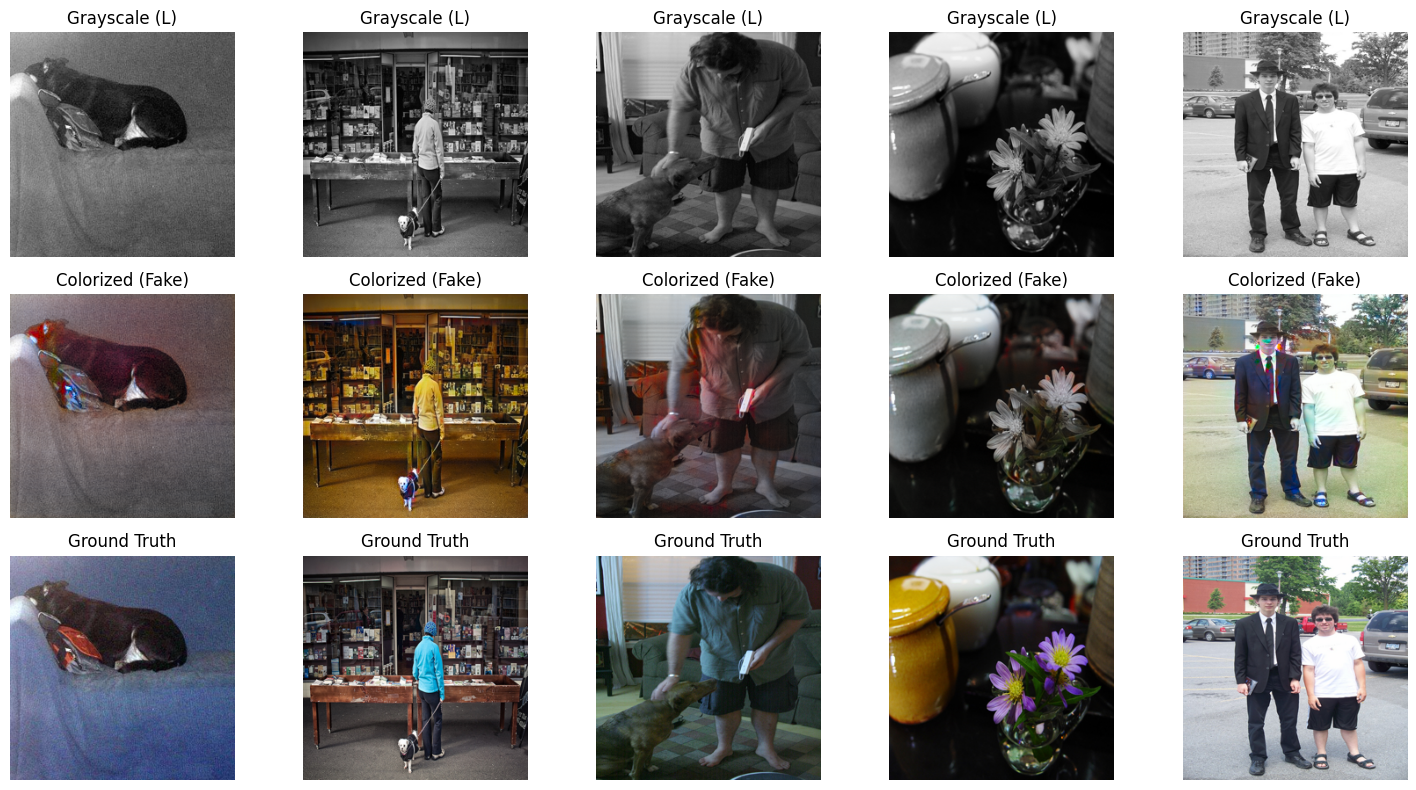

  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 11/20, Iteration 250/500
loss_D_fake: 0.61147
loss_D_real: 0.63079
loss_D: 0.62113
loss_G_GAN: 0.96023
loss_G_L1: 7.59843
loss_G: 8.55866

Epoch 11/20, Iteration 500/500
loss_D_fake: 0.61162
loss_D_real: 0.63011
loss_D: 0.62087
loss_G_GAN: 0.96003
loss_G_L1: 7.58817
loss_G: 8.54820


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 12/20, Iteration 250/500
loss_D_fake: 0.61059
loss_D_real: 0.63325
loss_D: 0.62192
loss_G_GAN: 0.95185
loss_G_L1: 7.48851
loss_G: 8.44036

Epoch 12/20, Iteration 500/500
loss_D_fake: 0.61056
loss_D_real: 0.63069
loss_D: 0.62062
loss_G_GAN: 0.95567
loss_G_L1: 7.47289
loss_G: 8.42857


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 13/20, Iteration 250/500
loss_D_fake: 0.61580
loss_D_real: 0.63059
loss_D: 0.62319
loss_G_GAN: 0.95591
loss_G_L1: 7.40665
loss_G: 8.36256

Epoch 13/20, Iteration 500/500
loss_D_fake: 0.61450
loss_D_real: 0.63101
loss_D: 0.62275
loss_G_GAN: 0.95229
loss_G_L1: 7.38023
loss_G: 8.33252


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 14/20, Iteration 250/500
loss_D_fake: 0.61478
loss_D_real: 0.62980
loss_D: 0.62229
loss_G_GAN: 0.94702
loss_G_L1: 7.30655
loss_G: 8.25357

Epoch 14/20, Iteration 500/500
loss_D_fake: 0.61287
loss_D_real: 0.62830
loss_D: 0.62058
loss_G_GAN: 0.94602
loss_G_L1: 7.28027
loss_G: 8.22628


  0%|          | 0/500 [00:00<?, ?it/s]


Epoch 15/20, Iteration 250/500
loss_D_fake: 0.61220
loss_D_real: 0.63178
loss_D: 0.62199
loss_G_GAN: 0.94572
loss_G_L1: 7.22690
loss_G: 8.17262

Epoch 15/20, Iteration 500/500
loss_D_fake: 0.61212
loss_D_real: 0.63197
loss_D: 0.62205
loss_G_GAN: 0.94422
loss_G_L1: 7.20427
loss_G: 8.14849

Displaying results for Epoch 15/20...



<ipython-input-21-d3827794e9e3>:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


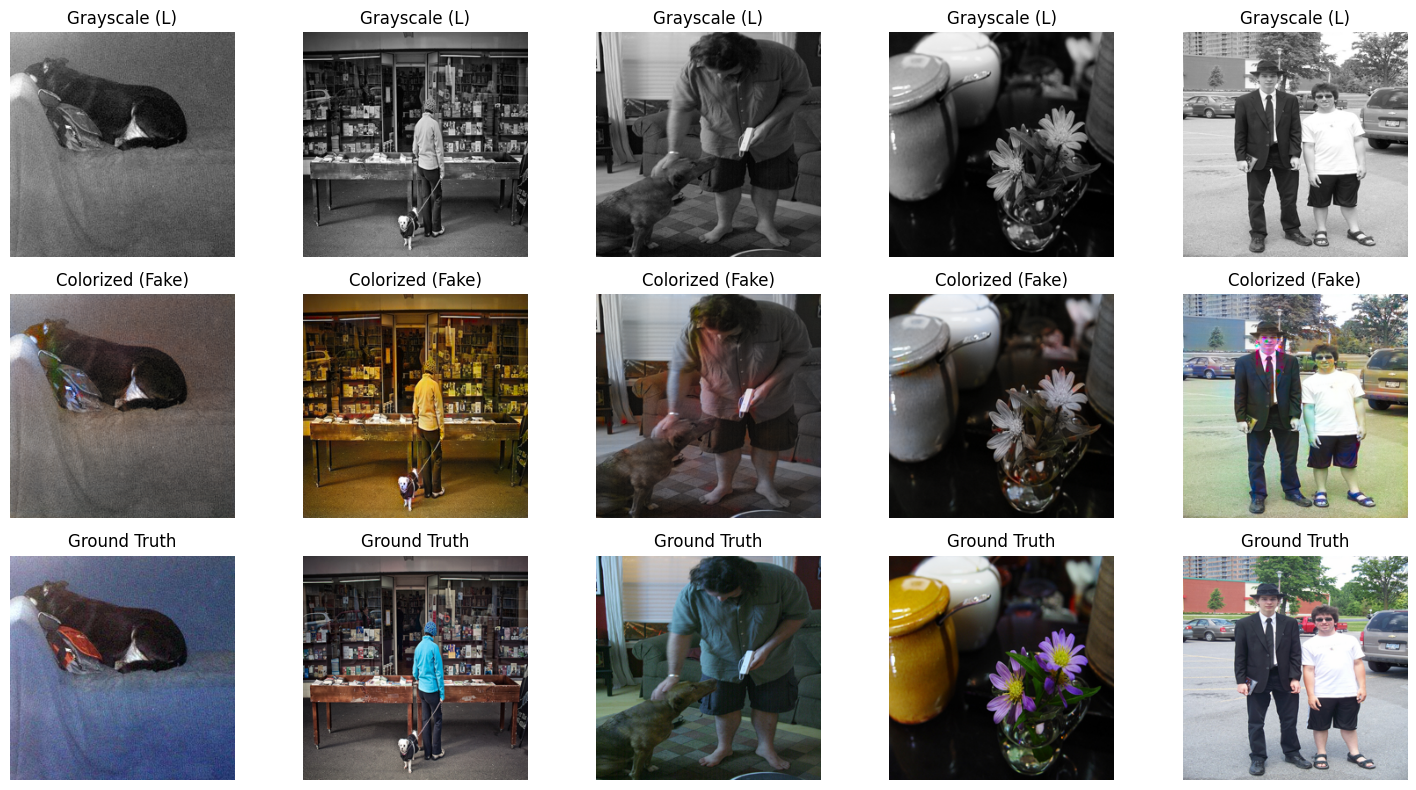

In [ ]:
model_path = "/content/drive/MyDrive/saved_model/2:Unet_colorization_model.pth"

# Load the entire Generator model
net_G = torch.load(model_path, map_location=device)
net_G.eval()  # Set to evaluation mode

# Pass the loaded Generator to MainModel
model = MainModel(net_G=net_G)

# Train the model with metrics and visualizations
train_model_with_metrics(model, train_dl, val_dl, epochs=20)


In [ ]:
final_model_path = os.path.join(save_path, "final_trained_model.pth")
torch.save(model, final_model_path)
print(f"Final trained model saved at: {final_model_path}")